In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,roc_curve, auc, precision_recall_curve, average_precision_score

In [92]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Printing the stopwords in English

In [93]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Data Preprocessing

In [94]:
hr_posts_dataset = pd.read_csv('C:/Users/DELL/Desktop/fake-hr-post-detection/data/fake_job_postings.csv')


In [95]:
hr_posts_dataset.shape

(17880, 18)

In [96]:
hr_posts_dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Counting the number of missing values in the dataset

In [97]:
hr_posts_dataset.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Replacing the missing values with empty strings

In [98]:
hr_posts_dataset = hr_posts_dataset.fillna('')

In [99]:
hr_posts_dataset.isnull().sum().sum()

np.int64(0)

Merging key columns to be used in prediction

In [100]:
hr_posts_dataset["text_content"] = (
    hr_posts_dataset["title"] + " " +
    hr_posts_dataset["company_profile"] + " " +
    hr_posts_dataset["description"] + " " +
    hr_posts_dataset["requirements"] + " " +
    hr_posts_dataset["benefits"]
)

In [101]:
print(hr_posts_dataset['text_content'])

0        Marketing Intern We're Food52, and we've creat...
1        Customer Service - Cloud Video Production 90 S...
2        Commissioning Machinery Assistant (CMA) Valor ...
3        Account Executive - Washington DC Our passion ...
4        Bill Review Manager SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution  Vend is looki...
17876    Payroll Accountant WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer  Nemsia Studios is looking fo...
17879    Web Application Developers Vend is looking for...
Name: text_content, Length: 17880, dtype: object


Stemming - process of reducing a word to its root word [eg: actor,actress,acting --> act]

In [102]:
port_stem = PorterStemmer()

In [103]:
stop_words = set(stopwords.words('english'))

In [128]:


def stemming(content):
    # 1. Lowercase
    stemmed_content = str(content).lower()

    # 2. Remove URLs
    stemmed_content = re.sub(r'http\S+|www\S+', '', stemmed_content)

    # 3. Remove digits and special chars (keep letters + spaces)
    stemmed_content = re.sub(r'[^a-z\s]', '', stemmed_content)

    # 4. Tokenize (split into words)
    stemmed_content = stemmed_content.split()

    # 5. Remove stopwords + apply stemming
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stop_words]

    # 6. Join back to text
    return " ".join(stemmed_content)


In [105]:
hr_posts_dataset['text_content'] = hr_posts_dataset['text_content'].apply(stemming)

Seperating the data and label

In [106]:
X = hr_posts_dataset['text_content'].values
Y = hr_posts_dataset['fraudulent'].values

In [107]:
print(X)

['market intern food weve creat groundbreak awardwin cook site support connect celebr home cook give everyth need one placew top editori busi engin team focus use technolog find new better way connect peopl around specif food interest offer superb highli curat inform food cook attract talent home cook contributor countri also publish wellknown profession like mario batali gwyneth paltrow danni meyer partnership whole food market random housefood name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today showwer locat chelsea new york citi food fastgrow jame beard awardwin onlin food commun crowdsourc curat recip hub current interview full parttim unpaid intern work small team editor execut develop new york citi headquartersreproduc andor repackag exist food content number partner site huffington post yahoo buzzfe variou content manag systemsresearch blog websit provis food affili programassist daytoday affili program support screen affili assist

In [108]:
print(Y)

[0 0 0 ... 0 0 0]


In [109]:
Y.shape

(17880,)

Feature Engineering:

Convert text → numeric features

In [126]:
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_vect = vectorizer.fit_transform(X)

In [111]:
print(X)

['market intern food weve creat groundbreak awardwin cook site support connect celebr home cook give everyth need one placew top editori busi engin team focus use technolog find new better way connect peopl around specif food interest offer superb highli curat inform food cook attract talent home cook contributor countri also publish wellknown profession like mario batali gwyneth paltrow danni meyer partnership whole food market random housefood name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today showwer locat chelsea new york citi food fastgrow jame beard awardwin onlin food commun crowdsourc curat recip hub current interview full parttim unpaid intern work small team editor execut develop new york citi headquartersreproduc andor repackag exist food content number partner site huffington post yahoo buzzfe variou content manag systemsresearch blog websit provis food affili programassist daytoday affili program support screen affili assist

Train-Test Split: splitting the dataset to training and test data

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vect,Y, test_size=0.2, stratify=Y, random_state=2)

Model training : Logistic Regression

In [113]:
model = LogisticRegression()

In [114]:
model.fit(X_train, Y_train)
#trains the model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Model Evaluation

In [115]:
#accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction,Y_train)
print('Accuracy score of the training data: ',training_data_accuracy)

Accuracy score of the training data:  0.9755313199105146


In [116]:
#accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
print('Accuracy score of the test data: ',test_data_accuracy)

Accuracy score of the test data:  0.9695190156599552


Visualizations & insights

In [117]:
sns.set(style="whitegrid")
%matplotlib inline

# quick sanity checks
print("Rows:", hr_posts_dataset.shape[0])
print("Label counts:\n", hr_posts_dataset['fraudulent'].value_counts())

Rows: 17880
Label counts:
 fraudulent
0    17014
1      866
Name: count, dtype: int64


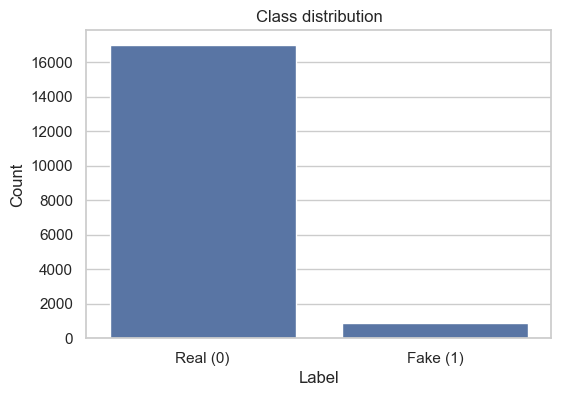

In [118]:
# Class distribution (bar chart) [shows class imbalance so we can interpret model metrics properly]

plt.figure(figsize=(6,4))
sns.countplot(x='fraudulent', data=hr_posts_dataset)
plt.xticks([0,1], ['Real (0)', 'Fake (1)'])
plt.title("Class distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


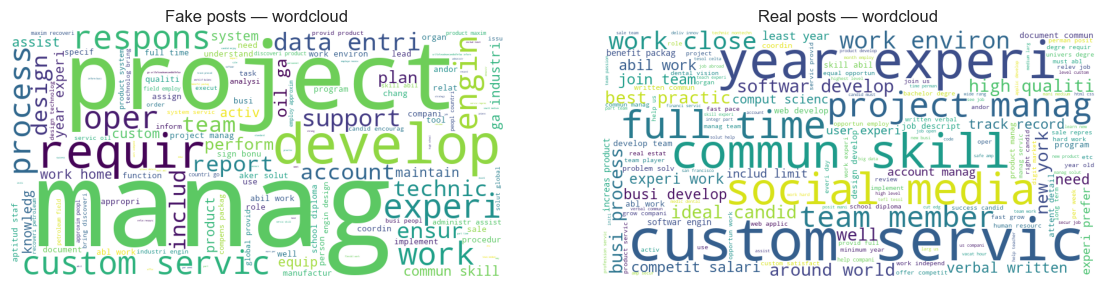

In [119]:
# WordClouds for each class (fast visual of frequent words)
# Make a single string per class
fake_text = " ".join(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==1, 'text_content'].dropna().astype(str).values)
real_text = " ".join(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==0, 'text_content'].dropna().astype(str).values)

wc = WordCloud(width=800, height=400, max_words=150, background_color="white")

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wc.generate(fake_text))
plt.axis('off')
plt.title("Fake posts — wordcloud")

plt.subplot(1,2,2)
plt.imshow(wc.generate(real_text))
plt.axis('off')
plt.title("Real posts — wordcloud")
plt.show()


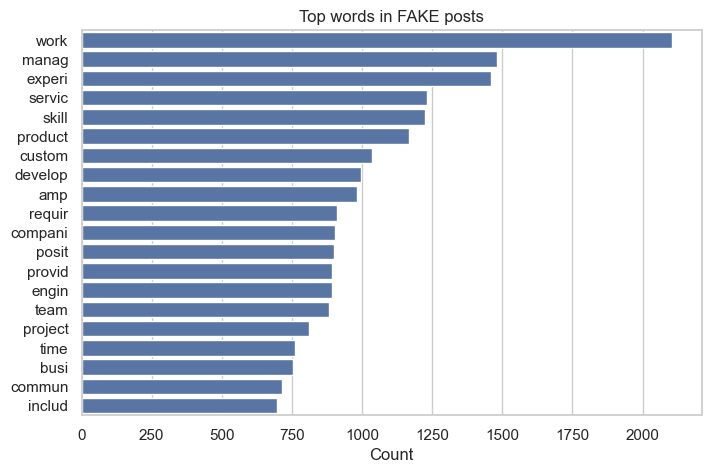

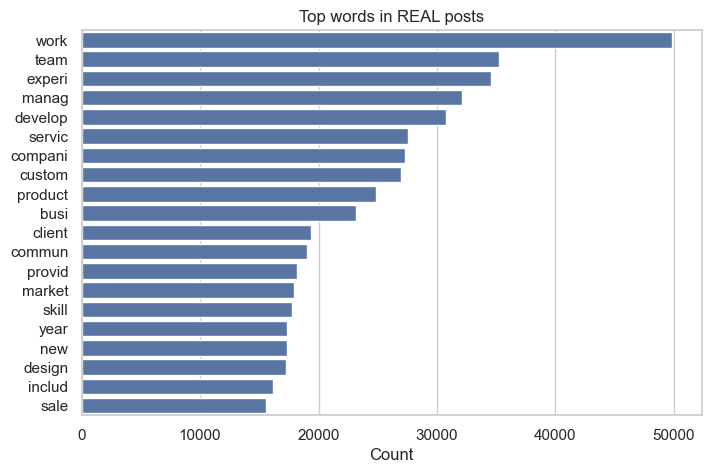

In [120]:
# Top-N words (bar plot) — CountVectorizer
def plot_top_n_words(corpus, n=20, title='Top words'):
    vect = CountVectorizer(stop_words='english', max_features=5000)
    X = vect.fit_transform(corpus)
    sums = np.array(X.sum(axis=0)).ravel()
    terms = np.array(vect.get_feature_names_out())
    top_idx = sums.argsort()[::-1][:n]
    top_terms = terms[top_idx]
    top_counts = sums[top_idx]
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_counts, y=top_terms)
    plt.title(title)
    plt.xlabel("Count")
    plt.show()

plot_top_n_words(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==1, 'text_content'], 20, "Top words in FAKE posts")
plot_top_n_words(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==0, 'text_content'], 20, "Top words in REAL posts")


C:\Users\DELL\AppData\Local\Temp\ipykernel_11596\2527771310.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==0,'text_len'], label='Real', shade=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11596\2527771310.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==1,'text_len'], label='Fake', shade=True)


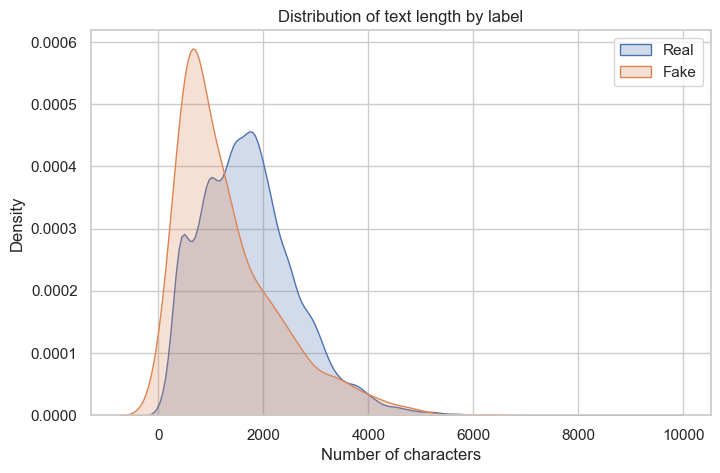

In [121]:
# Text length distribution by label
hr_posts_dataset['text_len'] = hr_posts_dataset['text_content'].astype(str).apply(len)
plt.figure(figsize=(8,5))
sns.kdeplot(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==0,'text_len'], label='Real', shade=True)
sns.kdeplot(hr_posts_dataset.loc[hr_posts_dataset['fraudulent']==1,'text_len'], label='Fake', shade=True)
plt.legend()
plt.title("Distribution of text length by label")
plt.xlabel("Number of characters")
plt.show()


In [122]:
# Most informative features (if you used Logistic Regression with TF-IDF)

# If you don't have model/tfidf variables, this will fit a quick logistic model for demonstration:
if 'tfidf' not in globals() or 'model' not in globals():
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    X_tfidf = tfidf.fit_transform(hr_posts_dataset['text_content'].fillna(''))
    model = LogisticRegression(max_iter=1000)
    model.fit(X_tfidf, hr_posts_dataset['fraudulent'])

# Extract top features
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_.ravel()
top_pos_idx = np.argsort(coefs)[-20:][::-1]   # top features for class 1 (fake)
top_neg_idx = np.argsort(coefs)[:20]          # top features for class 0 (real)

print("Top features indicative of FAKE posts:")
for i in top_pos_idx[:20]:
    print(feature_names[i], round(coefs[i], 4))

print("\nTop features indicative of REAL posts:")
for i in top_neg_idx[:20]:
    print(feature_names[i], round(coefs[i], 4))


Top features indicative of FAKE posts:
dutch 4.058
accid 3.5533
entiti 3.2331
assort 3.2169
ar 2.4915
peel 2.4216
airport 2.4209
model 2.3957
simultan 2.3855
pet 2.349
notch 2.3023
fundrais 2.2949
case 2.2191
strongli 2.1945
energi 2.1187
cleanli 2.0677
offercompetit 2.0292
contest 1.9926
highvolum 1.9567
improv 1.944

Top features indicative of REAL posts:
cleric -2.6821
tampa -2.2929
weapon -2.1153
dialer -1.7709
scientist -1.7685
emissionselectr -1.7136
greycroft -1.6516
sme -1.6292
water -1.6203
cardshou -1.5641
draw -1.5085
laboratori -1.4929
base -1.4708
mandarin -1.454
intercom -1.4284
engagor -1.4071
switch -1.4065
youhav -1.3836
ft -1.3476
smart -1.3348


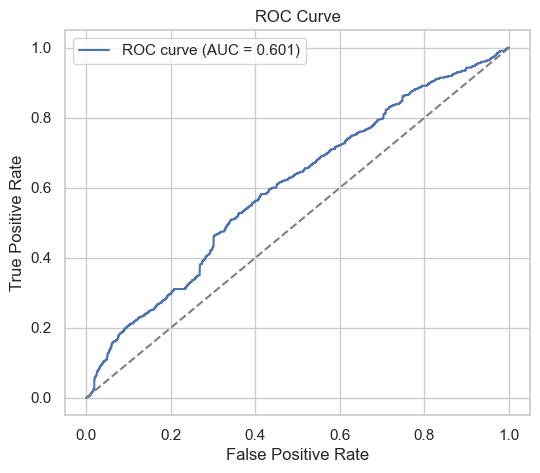

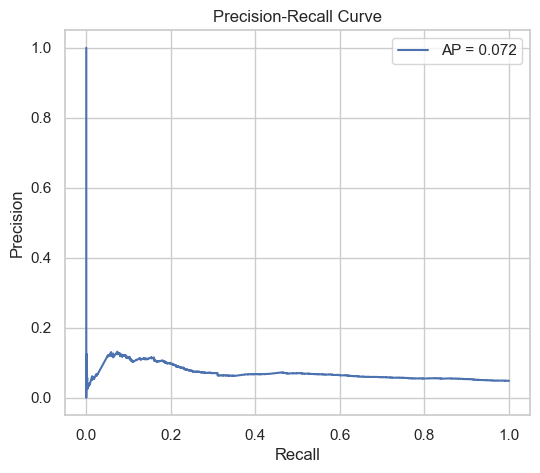

In [123]:
# ROC & Precision-Recall curves (model performance visual)
# Ensure model & vectorizer exist or fit a quick one (same as earlier)
X_all = tfidf.transform(hr_posts_dataset['text_content'].fillna(''))
y_all = hr_posts_dataset['fraudulent']

y_score = model.predict_proba(X_all)[:,1]

# ROC
fpr, tpr, _ = roc_curve(y_all, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR curve
precision, recall, _ = precision_recall_curve(y_all, y_score)
ap = average_precision_score(y_all, y_score)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {ap:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [124]:
import joblib

joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [125]:

joblib.dump(model, "model.pkl")

['model.pkl']